<h1>Open Haloscope</h1>
<h2>Simulation of the acquired data, of the expected signal and test of analysis technique</h2>

The input signals coming from the two electron spin resonances are basically two sine waves. The axion field modulates the spins' resonance frequency, thereby producing a phase modulation on one of the tones, here we assume that the axion signal is entirely contained in one of the two sine waves.

<h4>Imports and properties</h4>

In [1]:
import sys
sys.path.append(r"C:\Users\nicol\Progetti\Open Haloscope\lib")
experiments_folder = r"C:\Users\nicol\Progetti\Open Haloscope/data/experiments/"

#sys.path.append('/Users/ncr/Desktop/Progetti/Open-Haloscope/lib')
#experiments_folder = '/Users/ncr/Desktop/Progetti/Open-Haloscope/data/experiments/'

import open_haloscope.experiment as experiment
import open_haloscope.utils as utils

In [2]:
import numpy as np
from scipy.signal import periodogram, get_window
from scipy.optimize import curve_fit

import matplotlib.pyplot as plt

# plot options
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size=16)
#%config InlineBackend.figure_format='retina'

In [3]:
# colors
c1 = '#AC84DF'
c2 = '#918764'
c2a = '#639147'

In [4]:
haloscope_json = experiments_folder + 'kakapo_haloscope.json'
H = experiment.FermionicHaloscope(haloscope_json)

In [5]:
H.experiment_parameters

{'_parameters_Kakapo': 'Parameters used in the fermionic haloscope Kakapo',
 'haloscope_name': 'kakapo',
 'f': 5500000.0,
 'Q': 100,
 'f1': 5454690.349638967,
 'k1': 19403.521819088724,
 'f2': 5630663.245536586,
 'k2': 21375.62670037539,
 'An': 1e-05,
 'Ap': 1.0,
 'operating_frequency': 'MHz',
 'material_used': 'NiZn ferrite',
 'data_path': 'Open Haloscope\\data\\runs\\',
 'logs_path': 'Open Haloscope\\data\\logs\\',
 'redpitaya_eth0_ip': 'TCPIP::169.254.33.148::5000::SOCKET',
 'redpitaya_wlan_ip': 'TCPIP::192.168.1.30::5000::SOCKET'}

In [6]:
# sampling
sampling_frequency = H.sampling_frequency

# OH functions
dB = H.dB

<h3>Visualising an amplified axion effect</h3>

In [7]:
t, data1_amplified_axion, data2_amplified_axion = H.generate_simulated_run_data(number_of_traces=1,
                                                                                f1 = 5e6,
                                                                                f2 = 5e6,
                                                                                phase_noise = 1e-2,
                                                                                amplitude_noise = 1e-2, 
                                                                                axion_signal = True, 
                                                                                aa = 40, 
                                                                                fa = 0.1e6, 
                                                                                common_noise_frequency = 0.3e6, 
                                                                                common_noise_amplitude = 0.0)

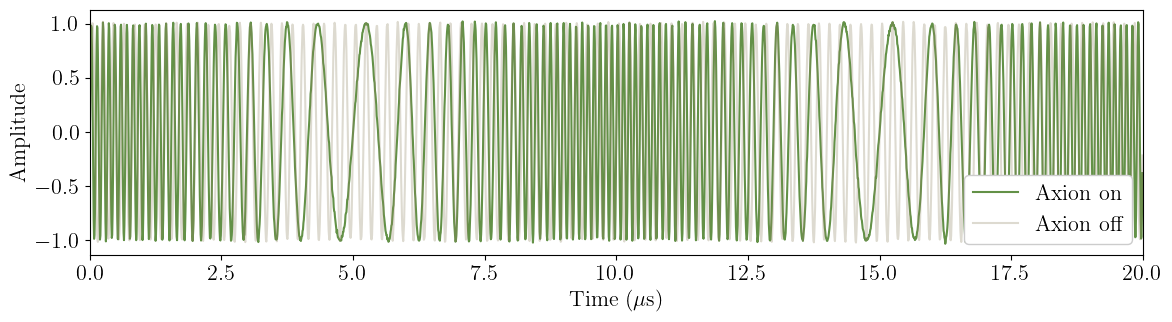

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12,3.5))
start = 0
stop = 2500
time_scale = 1e-6

ax.plot( t[start:stop] / time_scale, data1_amplified_axion[0][start:stop], label='Axion on', c=c2a )
ax.plot( t[start:stop] / time_scale, data2_amplified_axion[0][start:stop], label='Axion off', c=c2, alpha=0.3 )
ax.set_xlim([0,20])

ax.set_xlabel('Time ($\mathrm{\mu s}$)')
ax.set_ylabel('Amplitude')
ax.legend(loc='lower right', framealpha=1)

plt.tight_layout()
plt.savefig('axion_effect.pdf', dpi=300, bbox_inches='tight')

<h2>Data analysis</h2>

In [9]:
#t=np.linspace(0, 2**14-1, 2**14)
f1 = 5e6
f2 = 6e6
fa = 0.15e6
fc = 0.1e6

t, data1, data2 = H.generate_simulated_run_data(number_of_traces=1000,
                                                f1 = f1,
                                                f2 = f2,
                                                phase_noise = 1e-8,
                                                amplitude_noise = 1e-7, 
                                                axion_signal = True, 
                                                aa = 1e-4, 
                                                fa = fa, 
                                                common_noise_frequency = fc, 
                                                common_noise_amplitude = 1e-4)

In [10]:
s1n = data1[0]
s2n = data2[0]

# fourier transforms
psd_s1n = periodogram(s1n, fs = sampling_frequency, window = 'blackman')
psd_s2n = periodogram(s2n, fs = sampling_frequency, window = 'blackman')

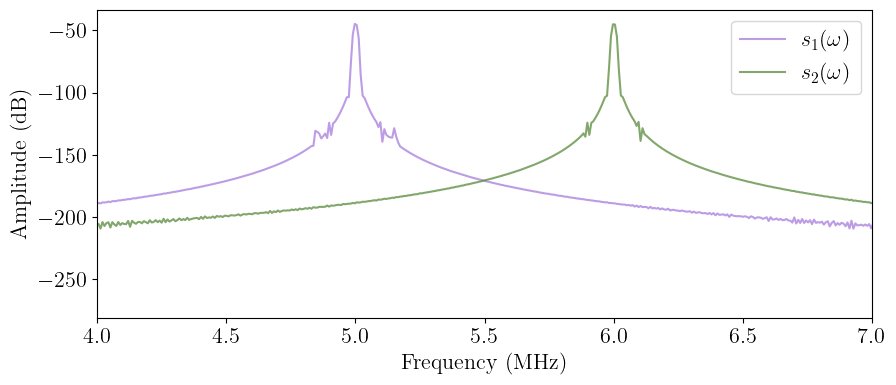

In [11]:
# plot the signals
fig, ax = plt.subplots(1, 1, figsize=(10,4))
frequency_scale = 1e6 # to MHz

ax.plot(psd_s1n[0] / frequency_scale, dB( psd_s1n[1] ), c=c1, alpha=0.8, label='$s_1(\omega)$')
ax.plot(psd_s2n[0] / frequency_scale, dB( psd_s2n[1] ), c=c2a, alpha=0.8, label='$s_2(\omega)$')
ax.set_xlim([4,7])
#ax.set_ylim([-150, 0])

ax.set_xlabel('Frequency (MHz)')
ax.set_ylabel('Amplitude (dB)')
ax.legend()

<h3>Extracting the signal</h3>
This part takes the simulated data and analyses them, in order to optimise the extraction of the axionic signal.
It follows the procedure used for the sideband interferometer devised by N.C. et al. but implements the procedure digitally. Since the expected signal is a phase modulation, it is better to work in the common phase noise rejection configuration, where the down-conversion signal phase is $\delta=\pi$.

In [12]:
delta_amp_rejection = np.pi / 2.00
delta_phase_rejection  = np.pi / 1.00

downconversion_frequency = (f1 + f2)/2
downconverted_frequency_origin = (f2 - f1)/2

downconversion_signal = np.sin( 2*np.pi * downconversion_frequency * t + delta_phase_rejection)

In [13]:
psd_s = periodogram((s1n + s2n) * downconversion_signal, fs=sampling_frequency, window='blackman')
downconverted_frequency = psd_s[0] - downconverted_frequency_origin

Text(0, 0.5, 'Amplitude (dB)')

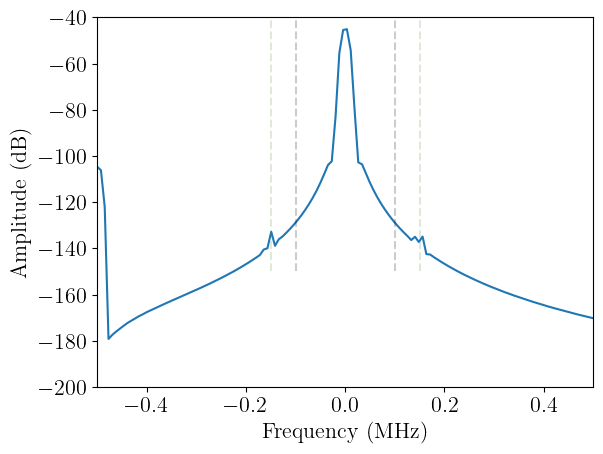

In [14]:
plt.plot(downconverted_frequency / frequency_scale, dB(psd_s[1]))
plt.vlines(-fa / frequency_scale, -150, 0, linestyle = 'dashed', color = c2a, alpha=0.2)
plt.vlines(fa / frequency_scale, -150, 0, linestyle = 'dashed', color = c2a, alpha=0.2)

plt.vlines(-fc / frequency_scale, -150, 0, linestyle = 'dashed', color = 'black', alpha=0.2)
plt.vlines(fc / frequency_scale, -150, 0, linestyle = 'dashed', color = 'black', alpha=0.2)

plt.xlim([-0.5, 0.5])
plt.ylim([-200, -40])
#plt.ylim([0, 1e-11])

plt.xlabel('Frequency (MHz)')
plt.ylabel('Amplitude (dB)')